# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FastTensorlineComputation folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FastTensorlineComputation")

Wall time: 0 ns


# Overview

In the following notebok we extract hyperbolic LCS from tensorlines of the eigenvector field associated to the minimum/maximum eigenvalue of the rate of strain tensor using the Fast Tensorline Computation. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data
 <br />
5. Hyperbolic OECS:

    * Compute rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $ using an auxiliary meshgrid. 
    <br />
    
    * Compute eigenvectors $ \mathbf{e}_i $ of the rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $.
    <br />
    
    * Hyperbolic OECS at time $ t $ are given by tensorlines starting from local maxima of $ s_2(x, y) $ which satisfy:
    <br />
    
    \begin{equation}
    S \mathbf{e}_i = s_i \mathbf{e}_i
    \label{eq: tensorlines}
    \end{equation}
    <br />
    
    $ \mathbf{e}_i $ denotes the eigenvector associated to the eigenvalue $ s_i $ of the rate of strain tensor $ S = S(\mathbf{x},t) $.
    The vector orthogonal to $ \mathbf{e}_i $ is denoted as $ \mathbf{e}_k $ and corresponds to the eigenvector associated to
    the eigenvalue $ s_k $ of $ S = S(\mathbf{x},t) $. The eigenvector field is a non-orientable vector field. Hence, computation of the tensorlines requires constant checking of the orientation of the eigenvector before performing the integration step. The integration has thus to be done manually and one cannot rely on an automatic ODE solver. The following method highlights a way to compute the tensorlines of $ \mathbf{S} $ without having the deal with the orientational discontinuities of the eigenvector field.
   <br />
    
   Tensorlines are parametrized curves $ \mathbf{x}_0(s) $ such that: 
   <br />
   
   \begin{equation}
   \mathbf{x}'_0(s) = \mathbf{e}_i(\phi(s))
   =\begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix}.
   \end{equation}
   Taking the derivative of \ref{eq: tensorlines} with
   respect to $ s $ leads to:
    
   \begin{align}
   (\nabla_x S \mathbf{e}_i)\mathbf{e}_i + S\mathbf{e}_k\phi' &= \langle \nabla_x s_i, \mathbf{e}_i \rangle I \mathbf{e}_i +
   s_i\mathbf{e}_k\phi' \\
   (S\mathbf{e}_k-s_i\mathbf{e}_k)\phi' &= (\langle \nabla_x s_i, \mathbf{e}_i \rangle I - (\nabla_x S \mathbf{e}_i))
   \mathbf{e}_i
   \end{align}

   Multiplying the above equation from the left with $ \mathbf{e}_k^T $ leads to:

   \begin{align}
            \mathbf{e}_k^T (S\mathbf{e}_k-s_i\mathbf{e}_k) \phi' &= \mathbf{e}_k^T(\langle \nabla_x s_i, \mathbf{e}_i \rangle I - (\nabla_x S \mathbf{e}_i)) \mathbf{e}_i \\
    (s_k-s_i) \phi' &= -\mathbf{e}_k^T(\nabla_x S \mathbf{e}_i) \mathbf{e}_i
    \end{align}
    
   where we used the property $ S\mathbf{e}_k = \lambda_k \mathbf{e}_k $ and $ \langle \mathbf{e}_i, \dfrac{d}{ds}\mathbf{e}_i
    \rangle = \langle \mathbf{e}_i, \mathbf{e}_k \rangle = 0 $ for an incompressible flow. Assuming again incompressibility $
    s_i = -s_k $ it eventually holds:

   \begin{equation}
    \phi' = -\dfrac{1}{2s_k}\mathbf{e}_k^T(\nabla_x S \mathbf{e}_i) \mathbf{e}_i
    \end{equation}

   For repelling OECS, the tensorlines satisfy the ODEs:

   \begin{align}
    x'(s) &= \cos(\phi(s)) \\
    y'(s) &= \sin(\phi(s)) \\
    \phi'(s) &= -\dfrac{1}{2s_2}\mathbf{e}_2^T(\nabla_x S \mathbf{e}_1) \mathbf{e}_1
    \end{align}

   For attracting OECS, the tensorlines satisfy the ODEs:

   \begin{align}
    x'(s) &= \cos(\phi(s)) \\
    y'(s) &= \sin(\phi(s)) \\
    \phi'(s) &= -\dfrac{1}{2s_1}\mathbf{e}_1^T(\nabla_x S \mathbf{e}_2) \mathbf{e}_2
    \end{align}    

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 112 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
%%time
import numpy as np

# Number of cores for parallel computing
Ncores = 4

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

Wall time: 0 ns


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# longitudinal and latitudinal boundaries (in degrees)
xmin = 2.75
xmax = 5.5
ymin = -38.25
ymax = -36.4

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and np.min(time_data) <= t_OECS <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"
    
# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Nx = X_domain.shape[0]
Ny = X_domain.shape[1]

Wall time: 0 ns


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 200 ms


# Rate of strain tensor

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x} $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid.

In [6]:
%%time
# Import package for parallel computing
from joblib import delayed, Parallel

# Import function to compute gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import function to check location of particle
from ipynb.fs.defs.check_location import check_location

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/10]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# Split x0, y0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_S(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
        
    # Compute gradient of velocity field
    grad_vel = gradient_velocity(t_OECS, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
    
    # Compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(1,0,2))

    return S

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S = results[0]

for i in range(1,len(results)):
    
    S = np.append(S, results[i], axis = 2)
    
# Reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
S = S.reshape((2, 2, X_domain.shape[0], X_domain.shape[1]))

Wall time: 3.09 s


# Compute tensorfield

In [7]:
# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Elements of rate of strain tensor and its gradients
S11 = np.nan_to_num(S[0,0,:,:], nan=0.0)
S12 = np.nan_to_num(S[0,1,:,:], nan=0.0)
S22 = np.nan_to_num(S[1,1,:,:], nan=0.0)

# Interpolate elements of rate of strain tensor (per default: cubic)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], S11)
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], S12)
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], S22)

# Initialize arrays
S11x = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S11y = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S12x = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S12y = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S22x = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
S22y = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
s = np.zeros((S11.shape[0], S11.shape[1]))*np.nan
e = np.zeros((S11.shape[0], S11.shape[1], 2))*np.nan

# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
    
# Iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        # compute maximum eigenvalue and maximum eigenvector of S
        s[i, j] = eigen(S[:, :, i, j])[1]
        e[i, j,:] =  eigen(S[:, :, i, j])[3]

# Interpolate $ \dot{\phi}(x, y, \phi), s_1(x, y), s_2(x, y) $ 

In [8]:
%%time
# Import phi_prime
from ipynb.fs.defs.phi_prime_OECS import _phi_prime_OECS

# Interpolant phi_phrime for attracting OECS
interp_phi_prime_attracting = _phi_prime_OECS(X_domain, Y_domain, -s, S11x, S11y, S12x, S12y, S22x, S22y)

# Interpolant phi_phrime for repelling OECS
interp_phi_prime_repelling = _phi_prime_OECS(X_domain, Y_domain, s, S11x, S11y, S12x, S12y, S22x, S22y)

# Import pacakge for interpolation
from scipy.interpolate import RectBivariateSpline as RBS

# interpolant for minimum eigenvalue-field
interp_s1 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(-s, nan = 0), kx=1, ky=1)

# interpolant for maximum eigenvalue-field
interp_s2 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(s, nan = 0), kx=1, ky=1)

Wall time: 33.1 s


# Find objective saddles

Objective saddles coincide with local maxima in the maximum eigenvalue field $ s $ of the rate of strain tensor.

In [9]:
from ipynb.fs.defs.loc_max import _loc_max

# minimum distance between objective saddles (=local maxima in the s-field)
min_distance = .75

# If tensorline is close to singularity 
# --> integration stops as eigenvector are no longer well defined.
# set threshold on rate of attraction which controls stopping criterion of integration.
# As a consequence, local maxima of the s-field which are below 'hyperbolicity' will be neglected
hyperbolicity = 0.15

# indices, positions and value (of s-field) of the objective saddles
loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(min_distance, X_domain, Y_domain, s, hyperbolicity)

# Compute Initial Conditions ($ x_0, y_0, \phi_0 $) for Hyperbolic OECS

For the spatial coordinates $ (x,y) $ the initial conditions $  x_0, y_0 $ coincide with the objective saddles (=local maxima in the s-field). The inital angle $ \phi_0 $ depends on the orientation of the eigenvector at $ (x_0,y_0) $. As the rate of strain tensor is symmetric, the eigenvectors are mutually orthogonal. As a consequence repelling and attracting OECS must necessarily always be orthogonal.

In [10]:
%%time
# Import math tools
from math import atan, cos, sin

# Initial positions from where to start integration of hyperbolic OECS
x0s1 = loc_max_x
y0s1 = loc_max_y

# Lists
phi0s1_repelling, phi0s1_attracting = [], []

# Iterate over all local maxima
for i in range(len(loc_idx_x)):
    
    # initial eigenvector
    eigenvector = e[loc_idx_y[i], loc_idx_x[i], :]
    
    # initial angle of eigenvector
    angle = atan(eigenvector[1]/eigenvector[0])%(2*np.pi)
    
    # tensorlines of repelling and attracting OECS must be orthogonal
    phi0s1_repelling.append(angle - np.pi/2)
    phi0s1_attracting.append(angle)

Wall time: 0 ns


# Compute Attracting/Repelling OECS

In [11]:
# Import ODEsolver
from scipy.integrate import solve_ivp

# Import function to calculate tensorline using the Fast Tensorline Computation algorithm
from ipynb.fs.defs.tensorline_equation import _tensorline_equation

# Import function to extract hyperbolic OECS from tensorline
from ipynb.fs.defs.extract_hyperbolic_OECS import _extract_hyperbolic_OECS

# Import package for progress bar
from tqdm.notebook import tqdm

# Define domain where velocity field is defined
defined_domain = np.isfinite(s).astype(int)

# Define lists containing the position and the rate of attracion/repulsion along 
# unstable/stable segments of the hyperbolic OECS
x_attracting, y_attracting, s_attracting = [], [], []
x_repelling, y_repelling, s_repelling = [], [], []

# Objective saddle location
objective_saddle = []

# Iterate over objective saddle-points (hyperbolic OECS)
for i in tqdm(range(len(x0s1))):
    
    # backward (-1) and forward (+1) integration
    for sign in [-1, 1]:
        
        # Define integration interval of dummy variable 's'
        t = [0, sign*5]
        
        # Define resolution of stable/unstable (repelling/attracting) segments of hyperbolic OECS
        t_eval = np.linspace(t[0], t[1], 1000)

        # Append objective saddle
        objective_saddle.append([x0s1[i], y0s1[i]])
        
        # IC repelling OECS
        x0_repelling = [x0s1[i], y0s1[i], phi0s1_repelling[i]]
        
        # IC repelling OECS
        x0_attracting = [x0s1[i], y0s1[i], phi0s1_attracting[i]]
        
        # Solve ODE for repelling OECS
        solREP = solve_ivp(_tensorline_equation, t, x0_repelling, 'RK45', t_eval, rtol=1e-8, atol=1e-8, args=(interp_phi_prime_repelling, hyperbolicity, interp_s1, X_domain, Y_domain, defined_domain))         
        
        # Solve ODE for attracting OECS
        solATTR = solve_ivp(_tensorline_equation, t, x0_attracting, 'RK45', t_eval, rtol=1e-8, atol=1e-8, args=(interp_phi_prime_attracting, hyperbolicity, interp_s2, X_domain, Y_domain, defined_domain))   
        
        # Extract attracting/repelling segments from the solution of the ODE as those segments
        # where the rate of attraction/repulsion |s1|=|s2| is monotonically decreasing
        x_repelling_OECS, y_repelling_OECS, s_repelling_OECS = _extract_hyperbolic_OECS(solREP.y[0,:], solREP.y[1,:], interp_s1) 
        x_attracting_OECS, y_attracting_OECS, s_attracting_OECS = _extract_hyperbolic_OECS(solATTR.y[0,:], solATTR.y[1,:], interp_s1) 
        
        # Append repelling/attracting OECS to list if it is not None
        if x_repelling_OECS is not None and x_attracting_OECS is not None:
        
            x_attracting.append(x_attracting_OECS)
            y_attracting.append(y_attracting_OECS)
            s_attracting.append(s_attracting_OECS)
        
            x_repelling.append(x_repelling_OECS)
            y_repelling.append(y_repelling_OECS)
            s_repelling.append(s_repelling_OECS)

  0%|          | 0/6 [00:00<?, ?it/s]

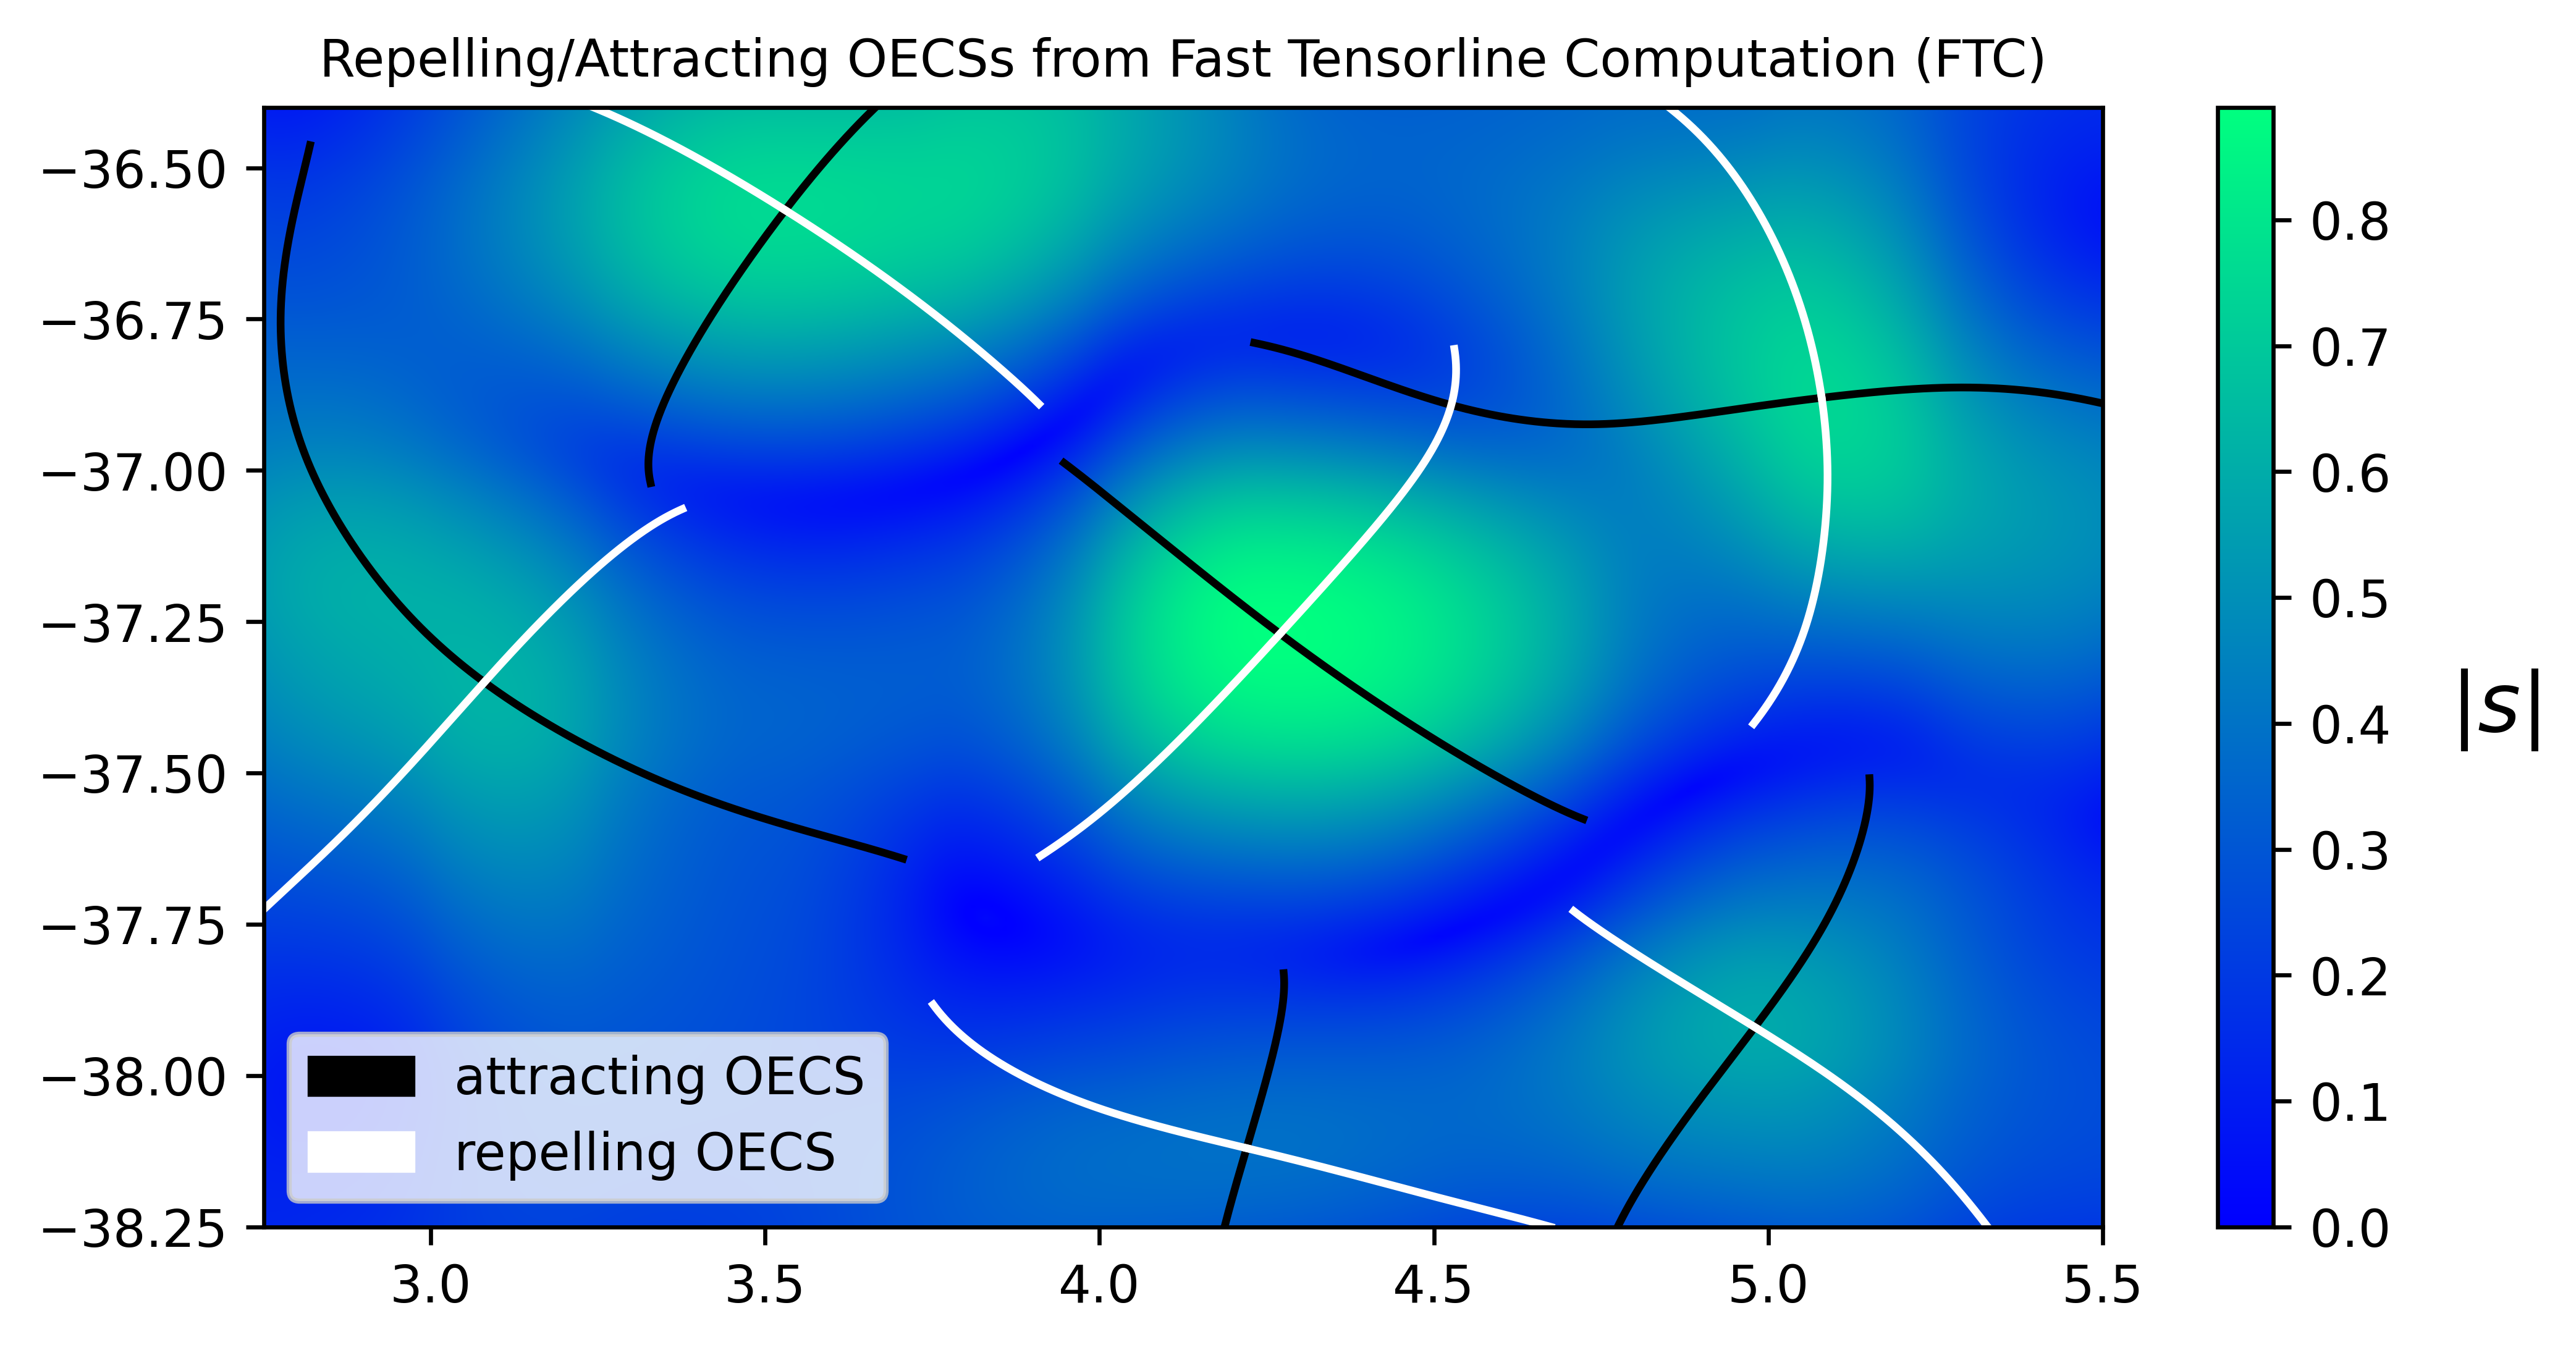

In [12]:
################################ PLOT HYPERBOLIC OECS ################################
import matplotlib.pyplot as plt

# generate figure and axis object
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Plot |s|-field
cax = ax.contourf(X_domain, Y_domain, np.abs(s), levels = 600, cmap = "winter")

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.1))
cbar.set_label(r'$ |s| $', rotation = 0, labelpad = 20, fontsize = 16)

# Plot attracting OECS
for i in range(len(x_attracting)):
    ax_attracting = ax.plot(x_attracting[i], y_attracting[i], c = "k", linewidth = 1.5)

# Plot repelling OECS
for j in range(len(x_repelling)):
    ax_repelling = ax.plot(x_repelling[j], y_repelling[j], c = "w", linewidth = 1.5)

# set limits
ax.set_xlim(np.min(X_domain), np.max(X_domain))
ax.set_ylim(np.min(Y_domain), np.max(Y_domain))

# Set title
ax.set_title('Repelling/Attracting OECSs from Fast Tensorline Computation (FTC)', fontsize = 10)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='k', label='attracting OECS')
repelling = mpatches.Patch(color='w', label='repelling OECS')
plt.legend(handles=[attracting, repelling], fontsize = 10, loc = "lower left")
 
# Show plot
plt.show()

It can be verified that the attracting/repelling OECS computed using the *Fast Tensorline Computation* coincide with those computed in [HyperbolicOECS](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/HyperbolicOECS/Main/HyperbolicOECS.ipynb). We note that this procedure is conceptually much easier as it does not require constantly checking the orientation of the eigenvector field and hence can be solved via an ODEsolver.

# Advect attracting OECS

Attracting/repelling OECS represent short term attractor/repellors of particles in the flow field. They act as the eulerian counterpart to hyperbolic LCS. Hyperbolic OECS act as a short-term unstable/stable manifold of a saddle point.
In order to highlight the validity of the extracted hyperbolic OECS and highlight the predictive power of attracting OECS for short time-intervals, we advect attracting OECSs up to 1.5 days and study their effect on nearby particles. We seed around every objective saddle a circular cluster of particles which gets advected by the flow. As shown in the figure below, the attracting OECS play a crucial role in shaping the deformation of the (initially circular) blobs as they stretch and attract the blobs originally centered around the objective saddle.

  0%|          | 0/12 [00:00<?, ?it/s]

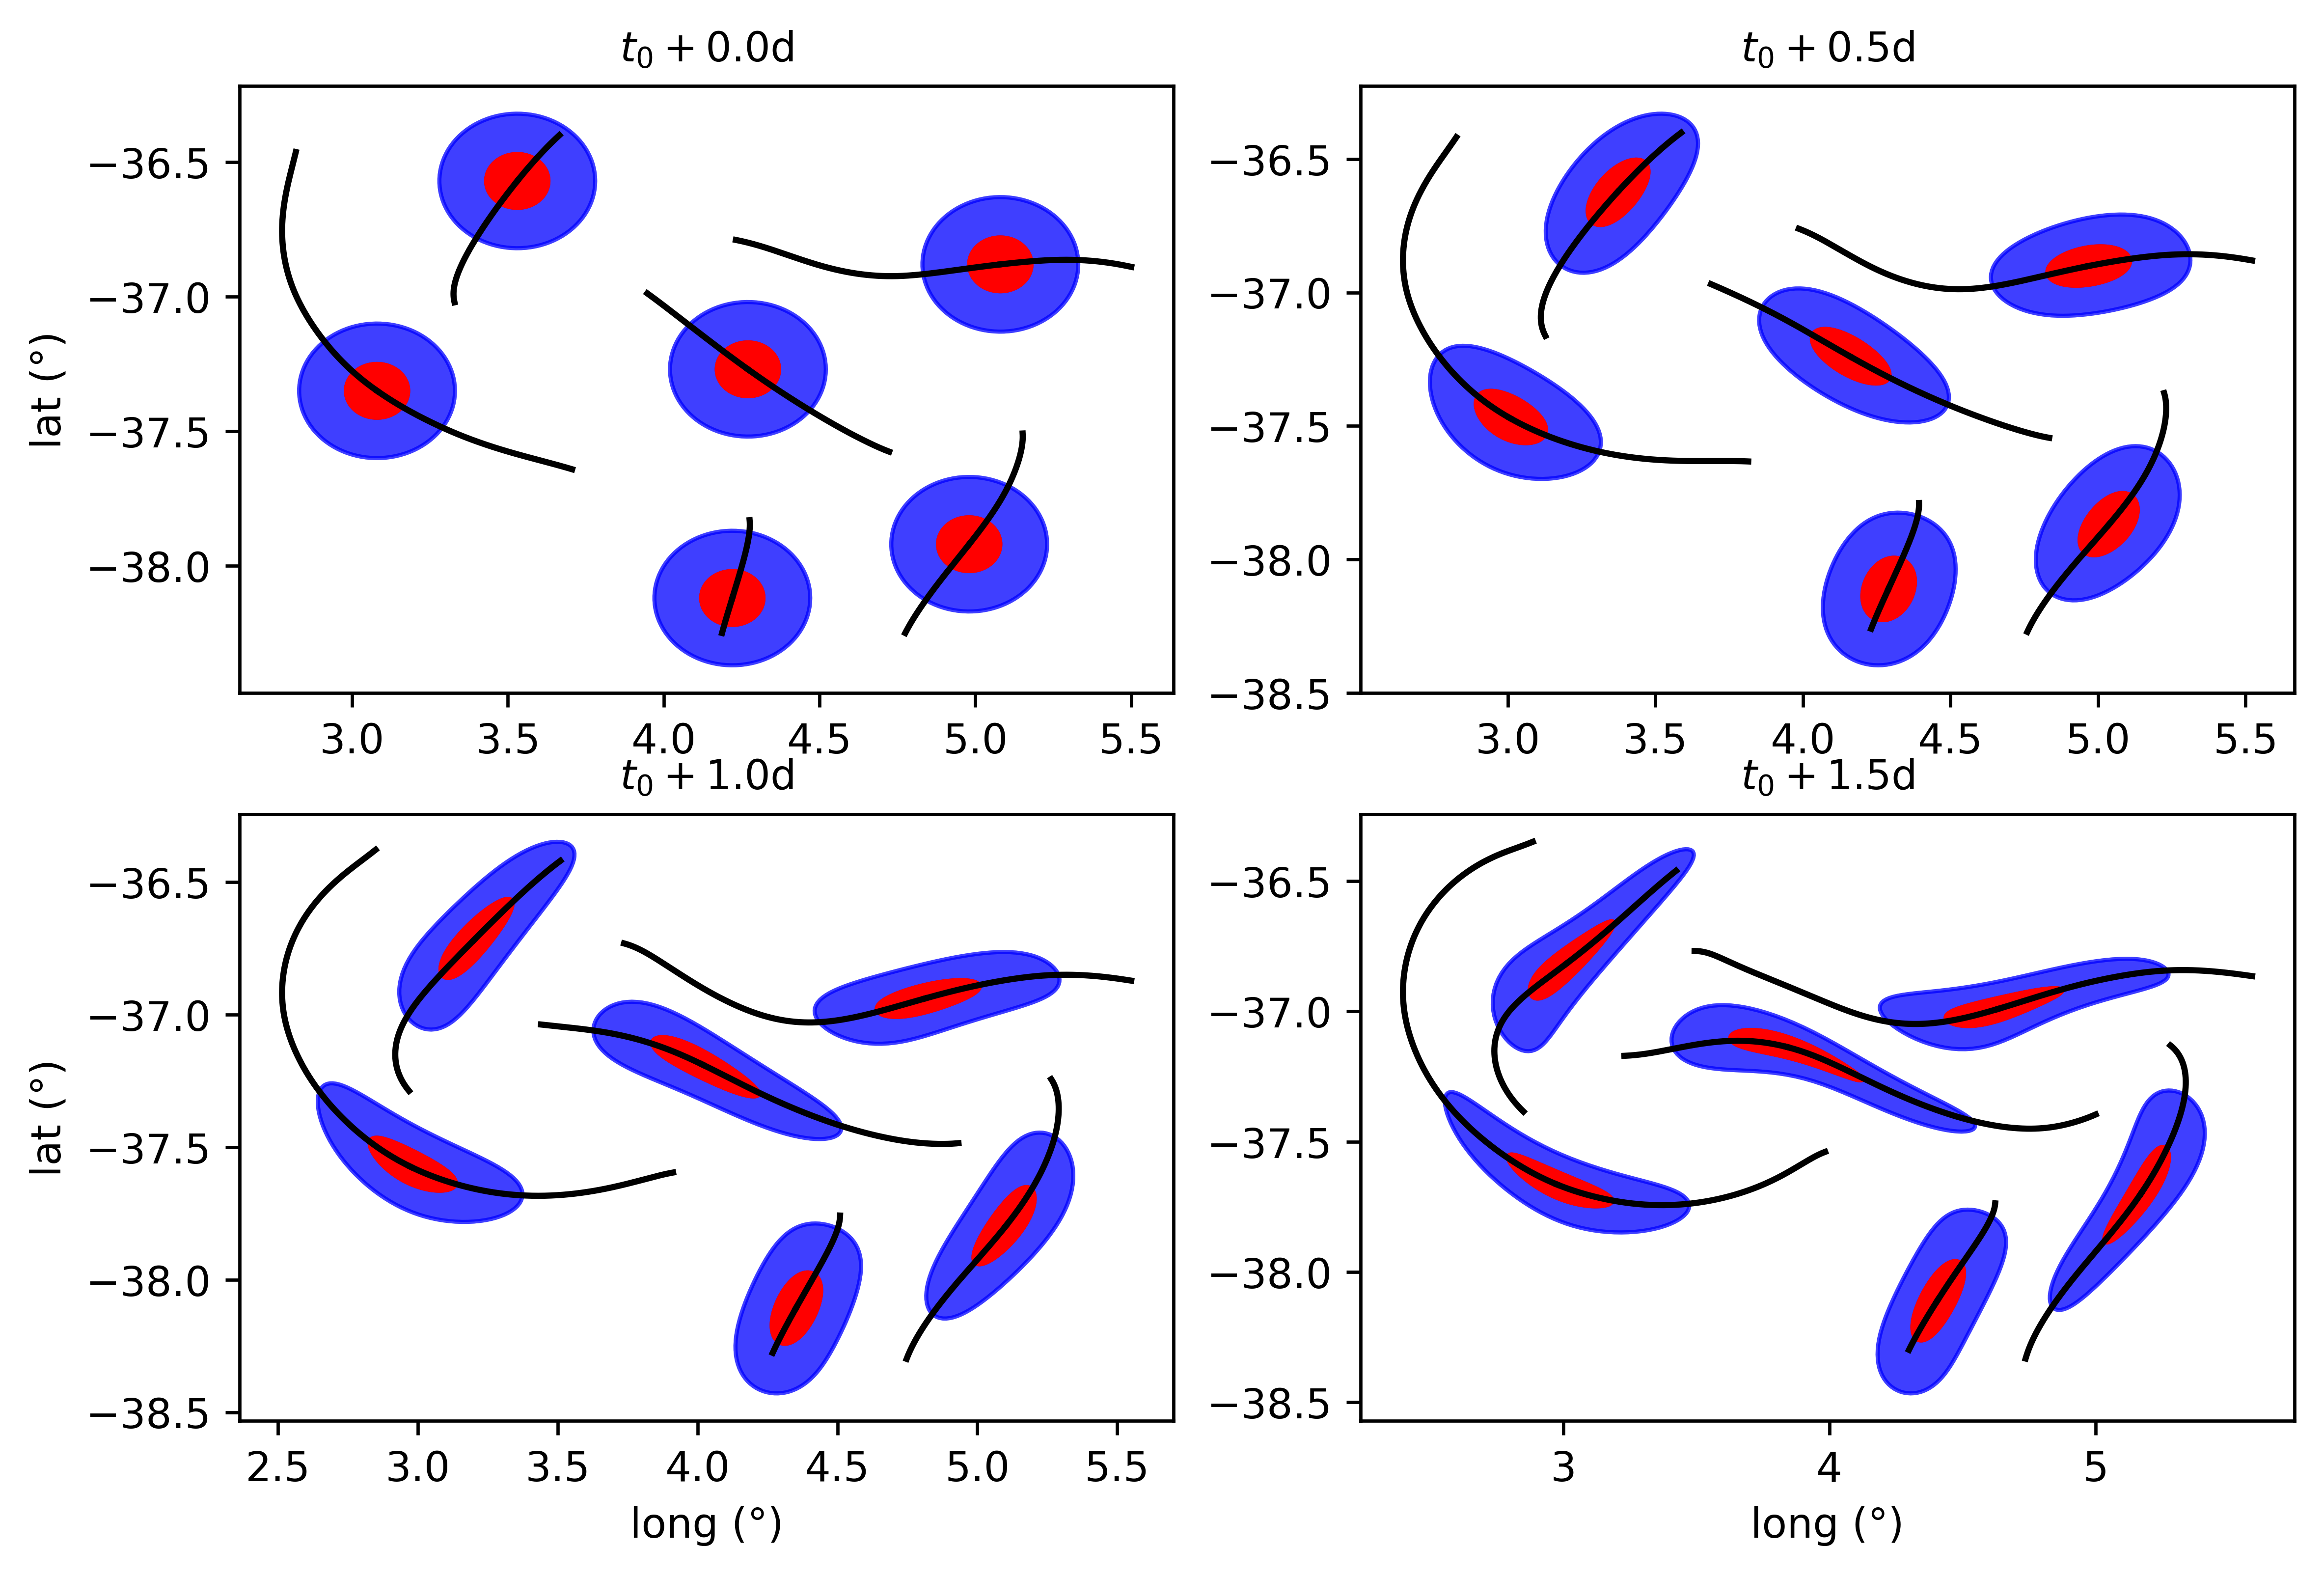

In [13]:
# Import package for computing trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# efine time-horizon over which to advect
time_advect = np.linspace(t_OECS, t_OECS+1.5, 151, endpoint = True)

t0 = 0
t1 = int(len(time_advect)/3)
t2 = int(2*len(time_advect)/3)
t3 = int(len(time_advect))-1

# Define figure/axes
# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(9, 6))

# Iterate over all attracting OECS and plot
for i in tqdm(range(len(objective_saddle))):
    
    x_advected, y_advected = [], []
        
    X0_attracting = np.array([x_attracting[i].ravel(), y_attracting[i].ravel()])
                    
    # Advect OECS over 1.5 days
    Fmap = integration_dFdt(time_advect, X0_attracting, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]
                    
    x_advected = Fmap[:, 0, :]
    y_advected = Fmap[:, 1, :]
    
    # create inner circle around objective saddle and seed it with particle
    r = 0.1
    x_inner_circle, y_inner_circle = [], []
    for phi in np.linspace(0, 2*np.pi, 100):
        x_inner_circle.append(objective_saddle[i][0]+r*np.cos(phi))
        y_inner_circle.append(objective_saddle[i][1]+r*np.sin(phi))
        
    # create outer circle around objective saddle and seed it with particle
    r = 0.25
    x_outer_circle, y_outer_circle = [], []
    for phi in np.linspace(0, 2*np.pi, 100):
        x_outer_circle.append(objective_saddle[i][0]+r*np.cos(phi))
        y_outer_circle.append(objective_saddle[i][1]+r*np.sin(phi))
        
    X0_inner_circle = np.array([x_inner_circle, y_inner_circle])
                    
    # Advect OECS over 3 days
    Fmap = integration_dFdt(time_advect, X0_inner_circle, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]
                    
    x_inner_circle_advected = Fmap[:, 0, :]
    y_inner_circle_advected = Fmap[:, 1, :]
    
    X0_outer_circle = np.array([x_outer_circle, y_outer_circle])
                    
    # Advect OECS over 3 days
    Fmap = integration_dFdt(time_advect, X0_outer_circle, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]
                    
    x_outer_circle_advected = Fmap[:, 0, :]
    y_outer_circle_advected = Fmap[:, 1, :]
    
    ax0.plot(x_advected[t0,:], y_advected[t0,:], linewidth = 1.5, c = "k")
    ax0.fill(x_outer_circle_advected[t0,:], y_outer_circle_advected[t0,:], c = "b", alpha = .5)
    ax0.fill(x_inner_circle_advected[t0,:], y_inner_circle_advected[t0,:], c = "r")
    
    ax1.plot(x_advected[t1,:], y_advected[t1,:], linewidth = 1.5, c = "k")
    ax1.fill(x_outer_circle_advected[t1,:], y_outer_circle_advected[t1,:], c = "b", alpha = .5)
    ax1.fill(x_inner_circle_advected[t1,:], y_inner_circle_advected[t1,:], c = "r")
    
    ax2.plot(x_advected[t2,:], y_advected[t2,:], linewidth = 1.5, c = "k")
    ax2.fill(x_outer_circle_advected[t2,:], y_outer_circle_advected[t2,:], c = "b", alpha = .5)
    ax2.fill(x_inner_circle_advected[t2,:], y_inner_circle_advected[t2,:], c = "r")
    
    ax3.plot(x_advected[t3,:], y_advected[t3,:], linewidth = 1.5, c = "k")
    ax3.fill(x_outer_circle_advected[t3,:], y_outer_circle_advected[t3,:], c = "b", alpha = .5)
    ax3.fill(x_inner_circle_advected[t3,:], y_inner_circle_advected[t3,:], c = "r")

# Set axis labels
ax2.set_xlabel("long (°)", fontsize = 10)
ax3.set_xlabel("long (°)", fontsize = 10)
ax0.set_ylabel("lat (°)", fontsize = 10)
ax2.set_ylabel("lat (°)", fontsize = 10)

# Title
ax0.set_title(r'$t_0+$'+str(np.around(time_advect[t0], 2))+"d", fontsize = 10)
ax1.set_title(r'$t_0+$'+str(np.around(time_advect[t1], 2))+"d", fontsize = 10)
ax2.set_title(r'$t_0+$'+str(np.around(time_advect[t2], 2))+"d", fontsize = 10)
ax3.set_title(r'$t_0+$'+str(np.around(time_advect[t3], 2))+"d", fontsize = 10)
plt.show();